In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Gold Futures Historical Data.csv')


In [4]:
df.head(3)

,Date,Price,Open,High,Low,Vol.,Change %
0,10-11-2025,"4,058.95","4,020.12","4,065.75","4,019.20",52.20K,0.97%
1,09-11-2025,"4,019.90","4,007.20","4,020.06","4,005.10",6.19K,0.25%
2,07-11-2025,"4,009.80","3,986.90","4,035.80","3,981.60",208.65K,0.47%


In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date').reset_index(drop=True)


In [6]:
# Clean price columns - remove commas and convert to float
price_cols = ['Price', 'Open', 'High', 'Low']
for col in price_cols:
    df[col] = df[col].str.replace(',', '').astype(float)

In [7]:

# Clean volume - remove 'K' and convert
df['Vol.'] = df['Vol.'].replace('', '0').str.replace('K', '').astype(float) * 1000

In [8]:
# Clean percentage
df['Change %'] = df['Change %'].str.replace('%', '').astype(float)

In [9]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (1249, 7)

First few rows:
        Date   Price    Open    High     Low      Vol.  Change %
0 2021-01-11  1850.8  1849.4  1856.0  1817.1  268360.0      0.84
1 2021-01-12  1844.2  1845.4  1864.0  1835.8  240660.0     -0.36
2 2021-01-13  1854.9  1855.0  1863.0  1841.6  225990.0      0.58
3 2021-01-14  1851.4  1845.6  1857.6  1826.6  257660.0     -0.19
4 2021-01-15  1829.9  1847.3  1856.6  1822.1  231110.0     -1.16


In [10]:
# Feature engineering - create technical indicators and lag features
df['MA_7'] = df['Price'].rolling(window=7).mean()
df['MA_14'] = df['Price'].rolling(window=14).mean()
df['MA_30'] = df['Price'].rolling(window=30).mean()

df['Volatility_7'] = df['Price'].rolling(window=7).std()
df['Volatility_14'] = df['Price'].rolling(window=14).std()

df['Price_Range'] = df['High'] - df['Low']
df['Price_Change'] = df['Price'].diff()

In [11]:
# RSI calculation
delta = df['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

In [12]:
# Lag features - previous day prices
for i in [1, 2, 3, 5, 7]:
    df[f'Price_Lag_{i}'] = df['Price'].shift(i)
    df[f'Volume_Lag_{i}'] = df['Vol.'].shift(i)

In [13]:
# Rolling statistics
df['Price_Rolling_Max_7'] = df['Price'].rolling(window=7).max()
df['Price_Rolling_Min_7'] = df['Price'].rolling(window=7).min()

In [14]:
# Day of week and month features
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [15]:
# Drop rows with NaN values from feature creation
df = df.dropna().reset_index(drop=True)

print(f"\nData after feature engineering: {df.shape}")


Data after feature engineering: (1202, 30)


In [16]:
# Prepare features and target
target_col = 'Price'
feature_cols = [col for col in df.columns if col not in ['Date', 'Price', 'Open', 'High', 'Low', 'Change %']]

X = df[feature_cols]
y = df[target_col]

In [17]:
# Split into train and test (80-20 split, time series order maintained)
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [18]:
print(f"\nTrain set: {X_train.shape}, Test set: {X_test.shape}")


Train set: (961, 24), Test set: (241, 24)


In [19]:
# Scale features for better performance
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Model 1: Random Forest
print("\n" + "="*60)
print("Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}, R²: {rf_r2:.4f}")


Training Random Forest Regressor...
Random Forest - RMSE: 689.21, MAE: 555.96, R²: -1.6367


In [21]:
# Model 2: Gradient Boosting
print("\nTraining Gradient Boosting Regressor...")
gb_model = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=7,
    min_samples_split=5,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)

gb_mse = mean_squared_error(y_test, gb_pred)
gb_rmse = np.sqrt(gb_mse)
gb_mae = mean_absolute_error(y_test, gb_pred)
gb_r2 = r2_score(y_test, gb_pred)

print(f"Gradient Boosting - RMSE: {gb_rmse:.2f}, MAE: {gb_mae:.2f}, R²: {gb_r2:.4f}")


Training Gradient Boosting Regressor...
Gradient Boosting - RMSE: 699.82, MAE: 567.03, R²: -1.7185


In [22]:
# Model 3: XGBoost
print("\nTraining XGBoost Regressor...")
xgb_model = XGBRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost - RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}, R²: {xgb_r2:.4f}")



Training XGBoost Regressor...
XGBoost - RMSE: 685.15, MAE: 549.93, R²: -1.6057


In [23]:
# Ensemble prediction - weighted average based on R² scores
total_r2 = rf_r2 + gb_r2 + xgb_r2
rf_weight = rf_r2 / total_r2
gb_weight = gb_r2 / total_r2
xgb_weight = xgb_r2 / total_r2

ensemble_pred = (rf_pred * rf_weight + gb_pred * gb_weight + xgb_pred * xgb_weight)

ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f"\nEnsemble Model - RMSE: {ensemble_rmse:.2f}, MAE: {ensemble_mae:.2f}, R²: {ensemble_r2:.4f}")
print("="*60)


Ensemble Model - RMSE: 691.49, MAE: 557.48, R²: -1.6541


In [24]:
# Feature importance from best model
best_model = xgb_model if xgb_r2 >= max(rf_r2, gb_r2) else (rf_model if rf_r2 >= gb_r2 else gb_model)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))



Top 10 Most Important Features:
                Feature  Importance
19  Price_Rolling_Max_7    0.485424
3                 MA_30    0.234722
9           Price_Lag_1    0.118853
1                  MA_7    0.071905
2                 MA_14    0.045722
20  Price_Rolling_Min_7    0.021897
11          Price_Lag_2    0.018949
13          Price_Lag_3    0.001363
7          Price_Change    0.000504
8                   RSI    0.000159


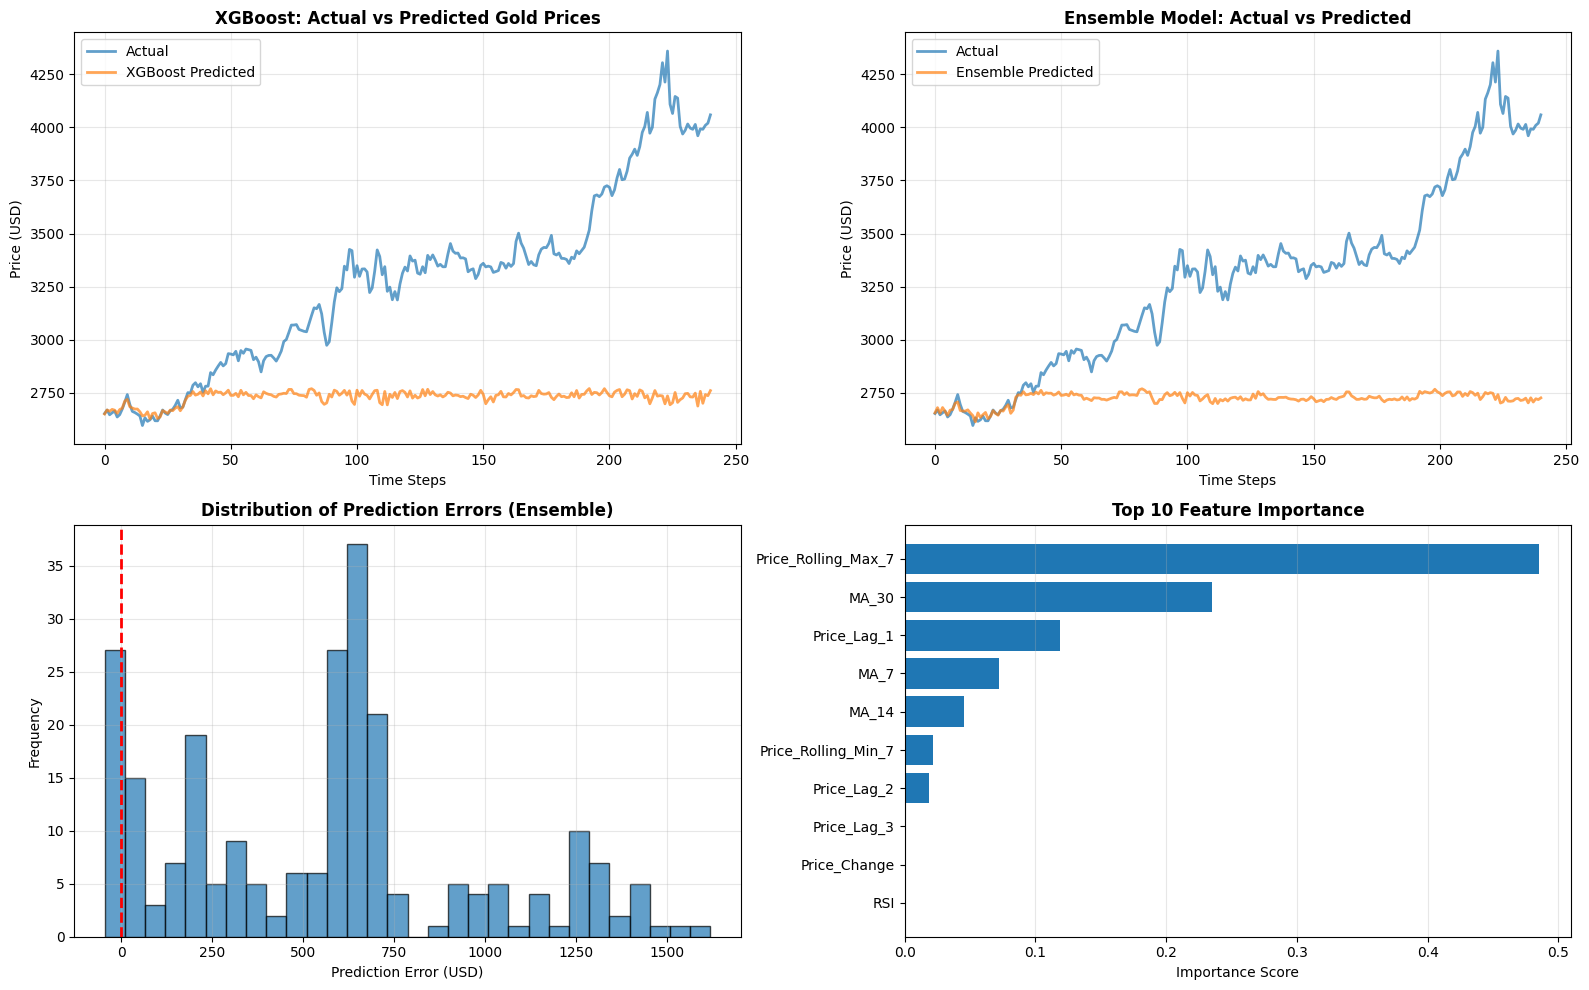

In [25]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Actual vs Predicted (XGBoost)
axes[0, 0].plot(y_test.values, label='Actual', linewidth=2, alpha=0.7)
axes[0, 0].plot(xgb_pred, label='XGBoost Predicted', linewidth=2, alpha=0.7)
axes[0, 0].set_title('XGBoost: Actual vs Predicted Gold Prices', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Time Steps')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Ensemble Model Performance
axes[0, 1].plot(y_test.values, label='Actual', linewidth=2, alpha=0.7)
axes[0, 1].plot(ensemble_pred, label='Ensemble Predicted', linewidth=2, alpha=0.7)
axes[0, 1].set_title('Ensemble Model: Actual vs Predicted', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Time Steps')
axes[0, 1].set_ylabel('Price (USD)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Prediction Errors
errors = y_test.values - ensemble_pred
axes[1, 0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Prediction Errors (Ensemble)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Prediction Error (USD)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Feature Importance
top_features = feature_importance.head(10)
axes[1, 1].barh(top_features['Feature'], top_features['Importance'])
axes[1, 1].set_title('Top 10 Feature Importance', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Importance Score')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('gold_forecast_results.png', dpi=300, bbox_inches='tight')
plt.show()



In [26]:
# Model comparison summary
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Ensemble'],
    'RMSE': [rf_rmse, gb_rmse, xgb_rmse, ensemble_rmse],
    'MAE': [rf_mae, gb_mae, xgb_mae, ensemble_mae],
    'R² Score': [rf_r2, gb_r2, xgb_r2, ensemble_r2]
})  

In [27]:
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))
print("="*60)

# Calculate percentage errors
mape = np.mean(np.abs((y_test - ensemble_pred) / y_test)) * 100
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")


MODEL PERFORMANCE COMPARISON
            Model       RMSE        MAE  R² Score
    Random Forest 689.212053 555.964480 -1.636692
Gradient Boosting 699.824839 567.026617 -1.718519
          XGBoost 685.146419 549.926932 -1.605677
         Ensemble 691.488693 557.482936 -1.654140

Mean Absolute Percentage Error (MAPE): 15.70%
